# Installing dependencies

In [ ]:
# !py -m pip install pyvista --upgrade
# !py -m pip install ipympl --upgrade
# !py -m pip install trame --upgrade
# !py -m pip install scipy --upgrade
# !py -m pip install shapely -- upgrade
# !py -m pip install tqdm -- upgrade

# Imports

In [1]:
import pyvista as pv
import numpy as np
import math

import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy import optimize
from scipy.special import comb

from math import sqrt, cos, sin, pi, atan2, degrees, floor

from shapely import affinity, distance
from shapely.geometry import Polygon, Point, LinearRing, LineString, MultiPoint
from shapely.plotting import plot_polygon, plot_points, plot_line
from shapely.ops import transform, nearest_points
from shapely.affinity import rotate

from tqdm.notebook import tqdm

# Input parameters

In [2]:
R = 75                  # radius of disk
n = 10000               # number of points along contours
r = R+2                 # initial ordinate of disk center

contain_percent = 0.2
max_delta_distance = 0.08
disk_delta_translation = 0.005

rough_filename = "data\\B4969-B_PLANNING_pear\\rough.obj"
diamond_filename = "data\\B4969-B_PLANNING_pear\\diamond.obj"

framerate = 20
draw_path = 'algo/pics/'

# Obtaining contours

In [ ]:

# def GetNextCycleContour(geom1_pts, geom2_pts, dst_delta):
#     geom1, geom2 = LineString(geom1_pts), LineString(geom2_pts)
#     rough_blgeom2 = LineString(geom2).parallel_offset(dst_delta, 'right', join_style=2)
#     spts, intersection_angles = GetSimpleOrderedIntersectionPoints(geom1, rough_blgeom2)

#     plot_line(geom1, add_points=False, color=(0.5,0.2,0))
#     plot_line(geom2, add_points=False, color=(0,0,1))
#     plot_line(rough_blgeom2, add_points=False, color=(0,1,0))
#     plot_points(spts, color=(0,0,0), markersize=5)

#     if len(spts) > 0:
#         # blgeom2_pts = CycleContour2Points(rough_blgeom2, geom2_pts)
#         blgeom2_pts = GetCycleContour(geom2_pts, rough_blgeom2)
#     else:
#         blgeom2 = GetTangentCycle(geom1, geom2)
#         spts, intersection_angles = GetSimpleOrderedIntersectionPoints(geom1, blgeom2)
#         # blgeom2_pts = CycleContour2Points(blgeom2, geom2_pts)
#         blgeom2_pts = GetCycleContour(geom2_pts, blgeom2)

#     mod_geom1 = LineString(rough_blgeom2).parallel_offset(dst_delta, 'left', join_style=2)
#     print(len(list(rough_blgeom2.coords)), len(list(mod_geom1.coords)), len(geom1_pts), len(geom2_pts))

#     return blgeom2_pts, spts

In [151]:
def matan(point):
    angle = atan2(point.y, point.x)
    if angle <= 0: angle += 2*pi
    return angle

def norma(point):
    return Point(0,0).distance(point)

def GetContourFromOBJ(filename):
    return LinearRing(MultiPoint(np.delete(pv.read(filename).project_points_to_plane().points, 2, 1)).convex_hull.boundary.coords)

def GetCornerIndices(pts, threshold):
    al = []
    for i in range(len(pts)):
        al.append([pts[i].x, pts[i].y])

    a = np.array(al)
    dx_dt = np.gradient(a[:, 0])
    dy_dt = np.gradient(a[:, 1])
    velocity = np.array([ [dx_dt[i], dy_dt[i]] for i in range(dx_dt.size)])

    ds_dt = np.sqrt(dx_dt * dx_dt + dy_dt * dy_dt)

    tangent = np.array([1/ds_dt]).transpose() * velocity

    tangent_x = tangent[:, 0]
    tangent_y = tangent[:, 1]

    deriv_tangent_x = np.gradient(tangent_x)
    deriv_tangent_y = np.gradient(tangent_y)

    dT_dt = np.array([ [deriv_tangent_x[i], deriv_tangent_y[i]] for i in range(deriv_tangent_x.size)])

    length_dT_dt = np.sqrt(deriv_tangent_x * deriv_tangent_x + deriv_tangent_y * deriv_tangent_y)

    normal = np.array([1/length_dT_dt]).transpose() * dT_dt

    d2s_dt2 = np.gradient(ds_dt)
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    curvature = np.abs(d2x_dt2 * dy_dt - dx_dt * d2y_dt2) / (dx_dt * dx_dt + dy_dt * dy_dt)**1.5
    t_component = np.array([d2s_dt2] * 2).transpose()
    n_component = np.array([curvature * ds_dt * ds_dt] * 2).transpose()

    acceleration = t_component * tangent + n_component * normal

    # plt.plot(curvature)
    return [idx for idx, val in enumerate(curvature) if val>=threshold]

def GetBaloonedContour(contour, baloon_distance):
    return LinearRing(LineString(contour).offset_curve(baloon_distance, quad_segs=int(2**5), join_style=1, mitre_limit=1.0))

def ClockwiseAngleAndDistance(point):
    origin, refvec = [0,0], [1,0]
    # Vector between point and the origin: v = p - o
    vector = [point[0]-origin[0], point[1]-origin[1]]
    # Length of vector: ||v||
    lenvector = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if lenvector == 0:
        return -math.pi, 0
    # Normalize vector: v/||v||
    normalized = [vector[0]/lenvector, vector[1]/lenvector]
    dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
    diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
    angle = math.atan2(diffprod, dotprod)
    # Negative angles represent counter-clockwise angles so we need to subtract them 
    # from 2*pi (360 degrees)
    if angle < 0:
        return 2*math.pi+angle, lenvector
    # Return first the angle because that's the primary sorting criterium
    # but if two vectors have the same angle then the shorter distance should come first.
    return angle, lenvector

def GetOrderedIntersectionPoints(geom1, geom2):
    intersection, pts, spts = geom1.intersection(geom2), [], []
    if intersection.geom_type == 'LineString':
        return [], []
    else:
        for geom in intersection.geoms: pts.append([geom.x, geom.y])
        pts = sorted(pts, key=ClockwiseAngleAndDistance)
        for pt in reversed(pts): spts.append(Point(pt[0], pt[1]))
        angle1, angle2 = matan(spts[0]), matan(spts[1])
        line = LineString([(0,0), (30*cos((angle1+angle2)/2), 30*sin((angle1+angle2)/2))])
        pt1, pt2 = geom1.intersection(line), geom2.intersection(line)
        if norma(pt1) < norma(pt2): spts.append(spts.pop(0))
        return spts, [matan(pt) for pt in spts]

def GetSimpleOrderedIntersectionPoints(geom1, geom2):
    intersection, pts, spts = geom1.intersection(geom2), [], []
    if intersection.geom_type == 'LineString':
        return [], []
    elif intersection.geom_type == 'Point':
        return [intersection], [matan(intersection)]
    else:
        for geom in intersection.geoms: pts.append([geom.x, geom.y])
        pts = sorted(pts, key=ClockwiseAngleAndDistance)
        for pt in reversed(pts): spts.append(Point(pt[0], pt[1]))
        return spts, [matan(pt) for pt in spts]

def Contour2Points(contour, begin_angle, n):
    contour_pts = []
    for i in range(n):
        angle = begin_angle + (i/n)*2*pi
        intersection = contour.intersection(LineString([(0,0), (30*cos(angle), 30*sin(angle))]))
        if intersection.geom_type == 'Point': contour_pts.append(intersection)
        else: contour_pts.append(intersection.geoms[-1])
    return contour_pts

def GetNormalVectors(geom_pts):
    normal_vectors = []
    for i in range(len(geom_pts)-1):
        pt1, pt2 = geom_pts[i], geom_pts[i+1]
        x1, y1 = pt1.x, pt1.y
        x2, y2 = pt2.x, pt2.y
        nrm = sqrt((x2-x1)**2+(y2-y1)**2)
        if abs(nrm) > 1e-14:
            normal_vectors.append(Point((y2-y1)/nrm, +(x2-x1)/nrm))
        else:
            normal_vectors.append(Point((y2-y1), +(x2-x1)))

    normal_vertices = []
    normal_vertices.append(normal_vectors[0])
    for i in range(len(normal_vectors)-1):
        x = (normal_vectors[i].x+normal_vectors[i+1].x)/2
        y = (normal_vectors[i].y+normal_vectors[i+1].y)/2
        nrm = sqrt(x**2+y**2)
        if abs(nrm) > 1e-14:
            normal_vertices.append(Point(x/nrm, y/nrm))
        else:
            normal_vertices.append(Point(x, y))
    normal_vertices.append(normal_vectors[-1])

    return normal_vertices

def CycleContour2Points(cycle_contour, geom_pts):
    normals = GetNormalVectors(geom_pts)
    contour_pts = []
    for i in range(len(geom_pts)):
        line = LineString([(0,0), (2*geom_pts[i].x, 2*geom_pts[i].y)])
        intersection = cycle_contour.intersection(line)
        if intersection.geom_type != 'Point':
            plot_line(line)
            plot_line(cycle_contour, add_points=False)
            plot_points(geom_pts, markersize=1)
            plt.xlim(1.5, 2.5)
            plt.ylim(2.5, 3.5)
            break
        contour_pts.append(intersection)
    # print(contour_pts)
    return contour_pts

def GetCycleContour(geom1_pts, blgeom2):
    normals = GetNormalVectors(geom1_pts)
    contour_pts, dst = [], 10
    for i in range(len(geom1_pts)):
        line = LineString([(geom1_pts[i].x, geom1_pts[i].y), (geom1_pts[i].x+dst*normals[i].x, geom1_pts[i].y+dst*normals[i].y)])
        intersection = blgeom2.intersection(line)
        contour_pts.append(intersection)
        # contour_pts.append(Point((geom1_pts[i].x+dst_delta*normals[i].x, geom1_pts[i].y+dst_delta*normals[i].y)))
    return contour_pts

def GetRotatedReperIndices(angles, intersection_angles):
    indices = []
    local_angles = [angle-intersection_angles[0] for angle in intersection_angles]
    # indices.append(0)
    for angle in local_angles:
        for i in range(len(angles)):
            if angles[i] > angle:
                indices.append(i)
                break
    # indices.pop(-1)
    return indices, len(indices)

def GetReperIndices(angles, intersection_angles):
    indices = []
    for angle in intersection_angles:
        for i in range(len(angles)):
            if angles[i] > angle:
                indices.append(i)
                break
    return indices, len(indices)

def GetNormals(pts, blpts, n):
    normals = []
    for i in range(n):
        x, y = blpts[i].x-pts[i].x, blpts[i].y-pts[i].y
        norm = sqrt(x**2+y**2)
        normals.append(Point(x/norm, y/norm))
    return normals

def GetEdges(pts, n):
    edges = []
    for i in range(n):
        x, y = pts[(i+1)%n].x-pts[i].x, pts[(i+1)%n].y-pts[i].y

def GetBaloonedContourWithContainPercentage(geom1, geom2, angles, n, contain_percent):
    delta = 1e-3
    bldistance = delta

    spts, intersection_angles = GetOrderedIntersectionPoints(geom1, geom2)
    if len(spts) > 0:
        indices, N = GetRotatedReperIndices(angles, intersection_angles)
        geom2_pts = Contour2Points(geom2, intersection_angles[0], n)
        contain_length = 0
        for j in range(N):
            i_min, i_max = indices[j], indices[(j+1)%N]
            contain_length += LineString(geom2_pts[i_min:i_max]).length
        current_contain_percent = contain_length / geom2.length
    else:
        current_contain_percent = 1

    iter = 0
    while current_contain_percent > contain_percent and iter < 1000:
        prev_contain_percent = current_contain_percent
        blgeom2 = GetBaloonedContour(geom2, bldistance)
        spts, intersection_angles = GetOrderedIntersectionPoints(geom1, blgeom2)
        if len(spts) > 0:
            indices, N = GetRotatedReperIndices(angles, intersection_angles)
            blgeom2_pts = Contour2Points(blgeom2, intersection_angles[0], n)
            contain_length = 0
            for j in range(0, N, 2):
                i_min, i_max = indices[j]-1, indices[(j+1)%N]-1
                contain_length += LineString(blgeom2_pts[i_min:i_max]).length
            if abs(contain_length) > 1e-5:
                current_contain_percent = contain_length / blgeom2.length
                # print(contain_length, geom1.length)
        if abs(prev_contain_percent-current_contain_percent) < 1e-3:
            delta *= 2
        elif abs(prev_contain_percent-current_contain_percent) > 1e-2:
            delta /= 2
        bldistance += delta
        iter += 1
        print(current_contain_percent, end="\r")
    return blgeom2, spts, current_contain_percent

def GetMaxDistance(geom1_pts, geom2):
    dst_max = 0.0
    for i in range(len(geom1_pts)):
        pt1, pt2 = nearest_points(geom2, geom1_pts[i])
        dst1, dst2 = geom1_pts[i].distance(pt1), geom1_pts[i].distance(pt2)
        dst = max(dst1, dst2)
        if dst > dst_max: dst_max = dst
    return dst_max

def GetTangentCycle(geom1, geom2):
    eps, intersection, bldistance = 2e-3, MultiPoint(), 0
    while intersection.geom_type == "MultiPoint":
        bldistance += eps
        blgeom2 = LineString(geom2).offset_curve(-bldistance, quad_segs=int(2**5), join_style=1, mitre_limit=1.0)
        intersection = geom1.intersection(blgeom2)
    return blgeom2
    
def GetNextCycleContour(geom1, geom2, dst_delta):
    blgeom2 = LineString(geom2).offset_curve(-dst_delta, quad_segs=int(2**5), join_style=1, mitre_limit=1.0)
    spts, intersection_angles = GetSimpleOrderedIntersectionPoints(geom1, blgeom2)
    if len(spts) == 0:
        blgeom2 = GetTangentCycle(geom1, geom2)
        spts, intersection_angles = GetSimpleOrderedIntersectionPoints(geom1, blgeom2)
    return blgeom2, spts

def GetNextUniformCycleContour(geom1, geom2, dst_delta):
    blgeom2 = geom2.offset_curve(dst_delta, quad_segs=int(2**5), join_style=1, mitre_limit=1.0)
    spts, intersection_angles = GetSimpleOrderedIntersectionPoints(geom1, blgeom2)
    return blgeom2, spts

def GetUniformGroundCycleContour(geom1, geom2, max_delta_distance):
    delta = 1e-3
    bldistance = delta
    blgeom2 = geom2

    iter, spts = 0, geom1.intersection(blgeom2)
    while spts.is_empty == True and iter < 1000:
        blgeom2 = geom2.offset_curve(bldistance, quad_segs=int(2**5), join_style=1, mitre_limit=1.0)
        spts = geom1.intersection(blgeom2)
        bldistance += delta
        iter += 1
    return blgeom2, spts

def GetPointOnLineWithDistance(line, distance):
    if distance < 0.0 or distance > line.length:
        return None
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return Point(coords[i][0], coords[i][1])
        if pd > distance:
           return line.interpolate(distance)

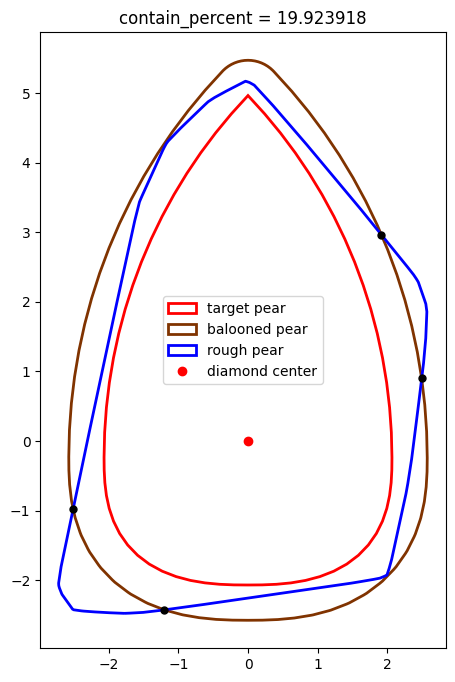

In [152]:
rough   = GetContourFromOBJ(rough_filename)
pear    = GetContourFromOBJ(diamond_filename)

angles = [2*pi*i/n for i in range(n)]
blpear, stps, real_contain_percent  = GetBaloonedContourWithContainPercentage(rough, pear, angles, n, contain_percent)

spts, intersection_angles = GetOrderedIntersectionPoints(rough, blpear)
indices, N = GetReperIndices(angles, intersection_angles)

rough_pts  = Contour2Points(rough, 0, n)
blpear_pts = Contour2Points(blpear, 0, n)

plot_line(pear, color=(1,0,0), add_points=False, label="target pear")
plot_line(blpear, color=(0.5,0.2,0),  add_points=False, label="balooned pear")
plot_points(stps, color=(0,0,0),  markersize=5)
plot_line(rough, color=(0,0,1),  add_points=False, label="rough pear")
plot_points(Point(0,0), color=(1,0,0), label="diamond center")

plt.rcParams["figure.figsize"] = (8.0, 8.0)
plt.title('contain_percent = ' + str(round(real_contain_percent*100, 6)))
plt.grid(False)
plt.legend()
plt.show()

In [156]:
pear_original_pts = [Point(pear.coords[i][0], pear.coords[i][1]) for i in range(len(pear.coords))]


In [81]:
# global_cycle_traces, global_sptss = [], []

# j = 0
# cycle_traces, sptss = [], []
# i_min, i_max = indices[j], indices[j+1]

# cycle_rough = LineString(rough_pts[i_min:i_max])
# cycle_ground = LineString(blpear_pts[i_min:i_max])

# dst_max = GetMaxDistance(rough_pts[i_min:i_max], cycle_ground)
# cycle_count = floor(dst_max / max_delta_distance)

# cycle_trace, spts = GetNextCycleContour(cycle_rough, cycle_ground, max_delta_distance)
# cycle_traces.append(cycle_trace)
# sptss.append(spts)

# global_cycle_traces.append(cycle_traces)
# global_sptss.append(sptss)

In [148]:
global_cycle_traces, global_sptss = [], []

# for j in range(0, 1, 2):
for j in range(2, 3, 2):
# for j in range(0, N, 2):
    cycle_traces, sptss = [], []
    i_min, i_max = indices[j], indices[j+1]

    cycle_rough = LineString(rough_pts[i_min:i_max])
    cycle_ground = LineString(blpear_pts[i_min:i_max])

    dst_max = GetMaxDistance(rough_pts[i_min:i_max], cycle_ground)
    cycle_count = floor(dst_max / max_delta_distance)

    # cycle_trace, spts = GetNextCycleContour(rough_pts[i_min:i_max], blpear_pts[i_min:i_max], max_delta_distance)
    cycle_trace, spts = GetNextCycleContour(cycle_rough, cycle_ground, max_delta_distance)
    cycle_traces.append(cycle_trace)
    sptss.append(spts)
    # if len(spts) > 1:
    #     cycle_indices, s = GetReperIndices(angles, [matan(pt) for pt in spts])
    # i_min_prev, i_max_prev = i_min, i_max

    for k in range(cycle_count):
        # i_min, i_max = cycle_indices[0], cycle_indices[1]
        # cycle_trace, spts = GetNextCycleContour(rough_pts[i_min:i_max], cycle_traces[-1][(i_min-i_min_prev):(i_max-i_min_prev)], max_delta_distance)
        cycle_trace, spts = GetNextCycleContour(cycle_rough, cycle_traces[-1], max_delta_distance)
        cycle_traces.append(cycle_trace)
        sptss.append(spts)
        # if len(spts) > 1:
        #     cycle_indices, s = GetReperIndices(angles, [matan(pt) for pt in spts])
        # i_min_prev, i_max_prev = i_min, i_max
    
    cycle_traces.reverse()
    sptss.reverse()
    global_cycle_traces.append(cycle_traces)
    global_sptss.append(sptss)

In [140]:
mod_global_cycle_traces, mod_global_sptss = [], []

# for j in range(0, 1, 2):
for j in range(2, 3, 2):
# for j in range(0, N, 2):
    cycle_traces, sptss = [], []
    i_min, i_max = indices[j], indices[j+1]
    count = i_max-i_min

    cycle_rough = LineString(rough_pts[i_min:i_max])
    cycle_ground = LineString(blpear_pts[i_min:i_max])

    dst_max = GetMaxDistance(rough_pts[i_min:i_max], cycle_ground)
    cycle_count = floor(dst_max / max_delta_distance)
    first_dst = dst_max - cycle_count*max_delta_distance

    line = global_cycle_traces[j-2][0]
    delta_len = line.length/(count-1)
    line_pts = []
    for i in range(count-1):
        line_pts.append(GetPointOnLineWithDistance(line, i*delta_len))
    line_pts.append(Point(line.coords[-1][0], line.coords[-1][1]))
    mod_line = LineString(line_pts)
    cycle_traces.append(mod_line)
    sptss.append([])

    for k in range(cycle_count):
        cycle_trace, spts = GetNextUniformCycleContour(cycle_rough, cycle_traces[-1], max_delta_distance)
        cycle_traces.append(cycle_trace)
        sptss.append(spts)

    cycle_trace, spts = GetUniformGroundCycleContour(cycle_ground, cycle_traces[-1], max_delta_distance)
    cycle_traces.append(cycle_trace)
    sptss.append([])
    
    mod_global_cycle_traces.append(cycle_traces)
    mod_global_sptss.append(sptss)

2465
2464
2464
2463
2460
2207
2177
2065
1768
1037


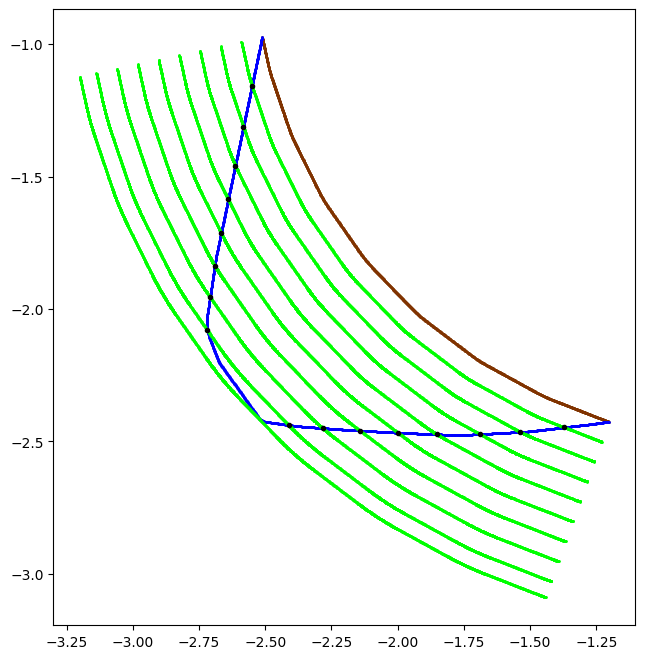

In [150]:
j = 2
if j < N-1:
    plot_points(blpear_pts[indices[j]:indices[j+1]], color=(0.5,0.2,0),  markersize=1)
    plot_points(rough_pts[indices[j]:indices[j+1]], color=(0,0,1),  markersize=1)
else:
    plot_points(blpear_pts[indices[j]:], color=(0.5,0.2,0),  markersize=1)
    plot_points(blpear_pts[:indices[0]], color=(0.5,0.2,0),  markersize=1)
    plot_points(rough_pts[indices[j]:], color=(0,0,1),  markersize=1)
    plot_points(rough_pts[:indices[0]], color=(0,0,1),  markersize=1)

# plot_line(pear, color=(1,0,0), add_points=False, label="target pear")
# plot_line(blpear, color=(0.5,0.2,0),  add_points=False, label="balooned pear")
# plot_line(rough, color=(0,0,1),  add_points=False, label="rough pear")
# plot_points(Point(0,0), color=(1,0,0), label="diamond center")

for j in range(len(global_cycle_traces)):
    for k in range(len(global_cycle_traces[j])):
        plot_points(global_cycle_traces[j][k], color=(0,1,0), markersize=1)
        plot_points(global_sptss[j][k], color=(0,0,0), markersize=3)
        print(len(list(global_cycle_traces[j][k].coords)))

# for j in range(len(mod_global_cycle_traces)):
#     for k in range(len(mod_global_cycle_traces[j])):
#         plot_points(mod_global_cycle_traces[j][k], color=(0,1,0), markersize=1)
#         plot_points(mod_global_sptss[j][k], color=(0,0,0), markersize=3)
#         print(len(list(mod_global_cycle_traces[j][k].coords)))

# j, k = 0, 0
# plot_points(global_cycle_traces[j][k], color=(0,1,0), markersize=1)
# plot_points(global_sptss[j][k], color=(0,0,0), markersize=3)

print(indices[j+1]-indices[j])

plt.grid(False)
# plt.legend()
plt.show()

In [213]:
j, k = 0, 0
print(global_cycle_traces[j][k])

# for j in range(len(global_cycle_traces)):
#     for k in range(len(global_cycle_traces[j])-1):
#         print(global_cycle_traces[j][k])
#         # line = LineString(global_cycle_traces[j][])
#         # dst_max = GetMaxDistance(global_cycle_traces[j][k], LineString(global_cycle_traces[j][k+1]))
#         # local_cycle_count = floor(dst_max / disk_delta_translation)
#         # print(local_cycle_count)

[<POINT (2.603 1.796)>, <POINT (2.603 1.798)>, <POINT (2.602 1.8)>, <POINT (2.602 1.802)>, <POINT (2.601 1.804)>, <POINT (2.601 1.806)>, <POINT (2.6 1.808)>, <POINT (2.6 1.81)>, <POINT (2.599 1.812)>, <POINT (2.598 1.814)>, <POINT (2.598 1.816)>, <POINT (2.597 1.818)>, <POINT (2.597 1.82)>, <POINT (2.596 1.822)>, <POINT (2.596 1.824)>, <POINT (2.595 1.826)>, <POINT (2.595 1.828)>, <POINT (2.594 1.831)>, <POINT (2.594 1.833)>, <POINT (2.593 1.835)>, <POINT (2.592 1.837)>, <POINT (2.592 1.839)>, <POINT (2.591 1.841)>, <POINT (2.591 1.843)>, <POINT (2.59 1.845)>, <POINT (2.59 1.847)>, <POINT (2.589 1.849)>, <POINT (2.589 1.851)>, <POINT (2.588 1.853)>, <POINT (2.588 1.855)>, <POINT (2.587 1.857)>, <POINT (2.586 1.859)>, <POINT (2.586 1.861)>, <POINT (2.585 1.864)>, <POINT (2.585 1.866)>, <POINT (2.584 1.868)>, <POINT (2.584 1.87)>, <POINT (2.583 1.872)>, <POINT (2.583 1.874)>, <POINT (2.582 1.876)>, <POINT (2.581 1.878)>, <POINT (2.581 1.88)>, <POINT (2.58 1.882)>, <POINT (2.58 1.884)>, <

# Constructing traces

In [ ]:
def GetReversed(pts):
    reversed_pts = []
    for i in reversed(range(len(pts))):
        reversed_pts.append(pts[i])
    return reversed_pts

def CreateDisk(n, R):
    disk_pts = []
    for i in range(n):
        angle = (i/n)*2*pi
        disk_pts.append(Point(R*cos(angle), R*sin(angle)))
    return disk_pts

def GetTrace(rough_pts, pear_pts, blpear_pts, angles, indices, normals, j, N, R):
    trace, rough_trace = [], []
    i_min, i_max, eps = indices[j], indices[(j+1)%N], 1e-3
    if j%2==0:
        for i in range(i_max-i_min):
            rough_trace.append(Point(rough_pts[i].x+R*normals[i].x, rough_pts[i].y+R*normals[i].y))
            
    else:
        trace = []

    return trace

In [ ]:
traces = []
for j in range(N):
    traces.append(GetTrace(rough_pts, pear_pts, blpear_pts, angles, indices, normals, j, N, R))